# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from tqdm.auto import tqdm
from collections import Counter
from math import ceil

# Data

In [2]:
data = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

In [3]:
data.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5


# EDA

In [4]:
REVIEW = 'Review Text'
CLASS = 'Rating'

**Stopwords** 
```
Add more stopwords to the list after EDA, words common to all rating classes
```

In [5]:
with open('stopwords.txt') as f:
    sw = map(lambda x : x.strip(), f.readlines())
stopwords = set(sw)|set(['dress'])
remove_stopwords = lambda x: ' '.join(word for word in x.split() if word not in stopwords)

In [6]:
print(sorted(stopwords))

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'ain', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'aren', "aren't", 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'computer', 'con', 'could', 'couldn', "couldn't", 'couldnt', 'cry', 'd', 'de', 'describe', 'detail', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'done', 'down', 'dress', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'f

In [7]:
data[REVIEW] = data[REVIEW].apply(lambda x : re.sub(r'\W', ' ', str(x)))
data[REVIEW] = data[REVIEW].apply(lambda x : re.sub(r'\d', ' ', str(x)))
data[REVIEW] = data[REVIEW].apply(lambda x : re.sub(r'\.', ' . ', str(x)))
data[REVIEW] = data[REVIEW].apply(lambda x : re.sub(r'\s+', ' ', str(x)))
data[REVIEW] = data[REVIEW].apply(lambda x : x.strip())
data[REVIEW] = data[REVIEW].apply(lambda x: x.lower())
data[REVIEW] = data[REVIEW].apply(remove_stopwords)

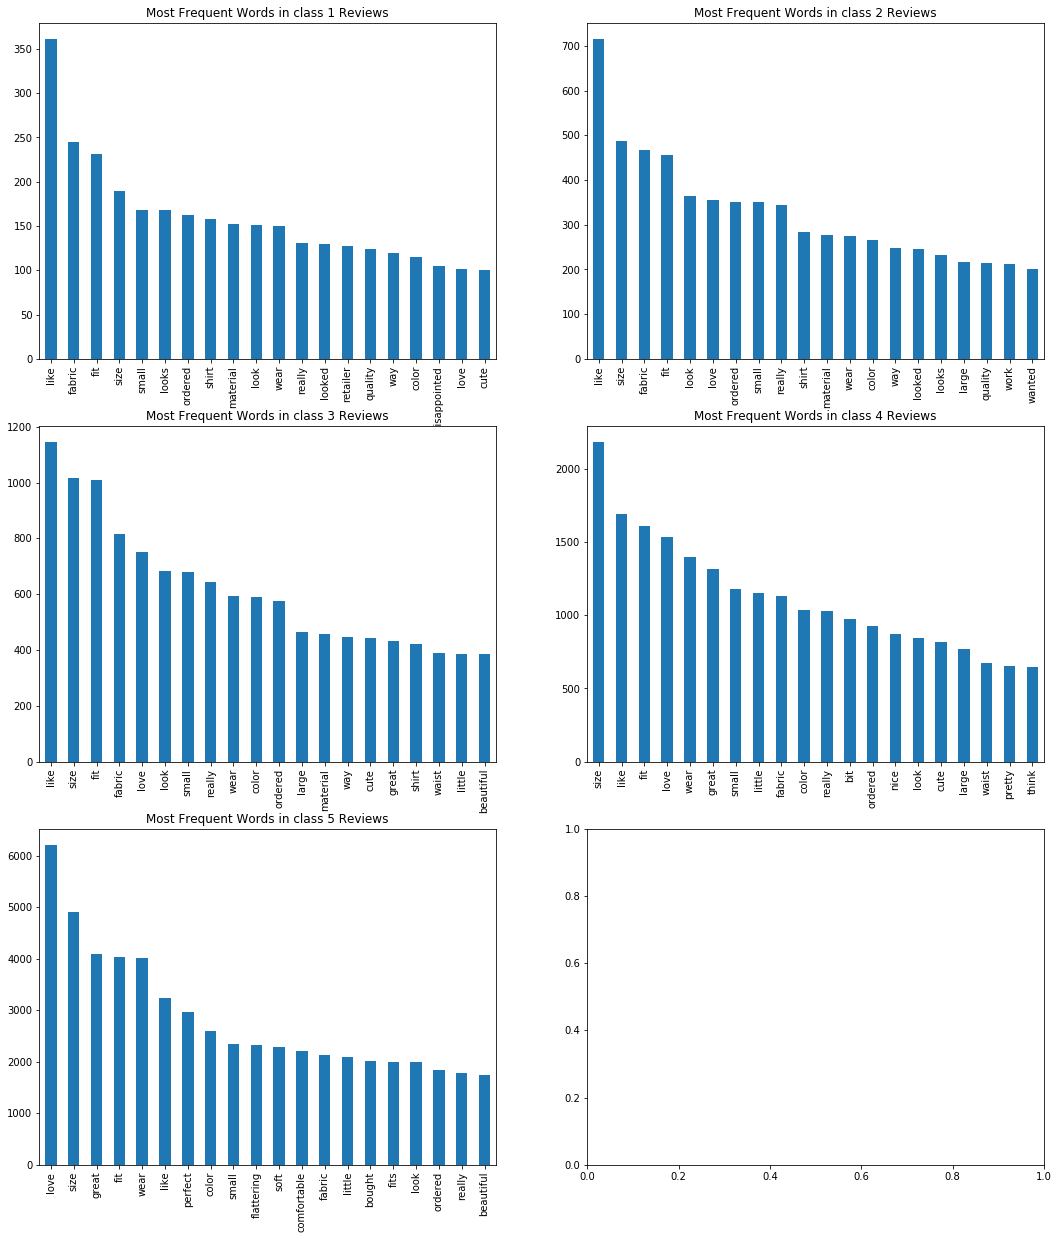

In [8]:
classes = sorted(data[CLASS].unique())
fig, ax = plt.subplots(figsize=(18,int(7*ceil(len(classes)/2))), nrows=ceil(len(classes)/2), ncols=2)
for i, c in enumerate(classes):
    pd.Series(' '.join(data[data[CLASS]==c][REVIEW]).lower().split()).value_counts()[:20].plot.bar(ax = ax[i//2][i%2])
    ax[i//2][i%2].set_title(f'Most Frequent Words in class {c} Reviews')

In [9]:
droplist = list(stopwords)+['taj', 'mahal', 'i', 'delhi', 'india']
adjectives = ['JJ', 'JJR', 'JJS']
verbs = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
nouns = ['NN', 'NNS', 'NNP', 'NNPS']
adverbs = ['RB', 'RBR', 'RBS']
def relations(x):
    insights = []
    tags = pos_tag(word_tokenize(x.lower()))
    for i in range(len(tags)):
        if tags[i][0] not in droplist:
            if tags[i][1] in adjectives:
                # Adjective -> search for nearest noun (after)
                # after
                j = i
                while j < len(tags):
                    if tags[j][1] in nouns and tags[j][0] not in droplist:
                        insights.append(tags[i][0]+' '+tags[j][0])
                        break
                    if tags[j][0] == '.':
                        break
                    j += 1
                # before
                j = i
                while j > 0:
                    if tags[j][1] in nouns and tags[j][0] not in droplist:
                        insights.append(tags[i][0]+' '+tags[j][0])
                        break
                    if tags[j][0] == '.':
                        break
                    j -= 1
            elif tags[i][1] in adverbs:
                # Adjverb -> search for nearest verb (before)
                 # after
                j = i
                while j < len(tags):
                    if tags[j][1] in verbs and tags[j][0] not in droplist:
                        insights.append(tags[j][0]+' '+tags[i][0])
                        break
                    if tags[j][0] == '.':
                        break
                    j += 1
                # before
                j = i
                while j > 0:
                    if tags[j][1] in verbs and tags[j][0] not in droplist:
                        insights.append(tags[j][0]+' '+tags[i][0])
                        break
                    if tags[j][0] == '.':
                        break
                    j -= 1
            elif tags[i][1] in nouns:
                # noun -> search for nearest adjective (before)
                # after
                j = i
                while j < len(tags):
                    if tags[j][1] in adjectives and tags[j][0] not in droplist:
                        insights.append(tags[j][0]+' '+tags[i][0])
                        break
                    if tags[j][0] == '.':
                        break
                    j += 1
                # before
                j = i
                while j > 0:
                    if tags[j][1] in adjectives and tags[j][0] not in droplist:
                        insights.append(tags[j][0]+' '+tags[i][0])
                        break
                    if tags[j][0] == '.':
                        break
                    j -= 1
    return insights

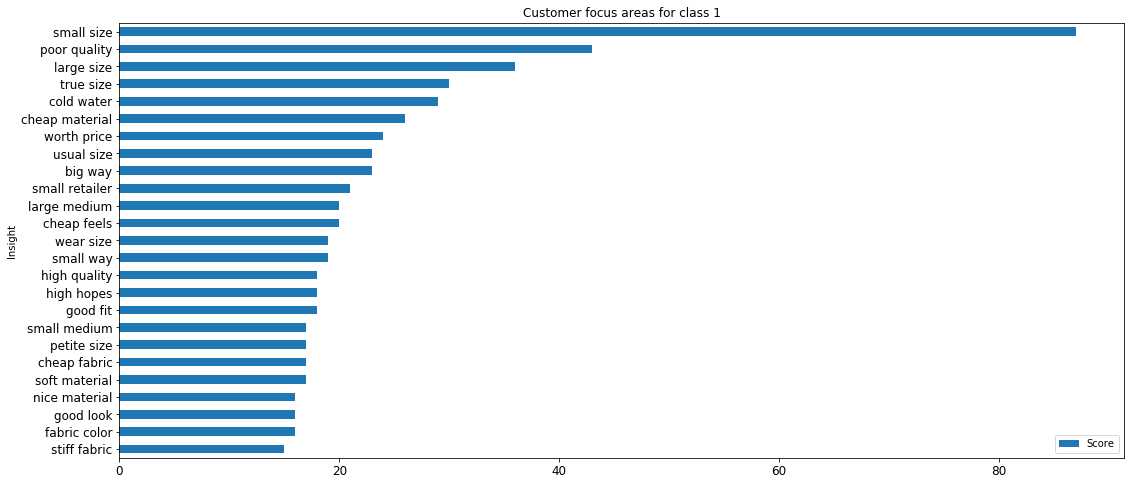

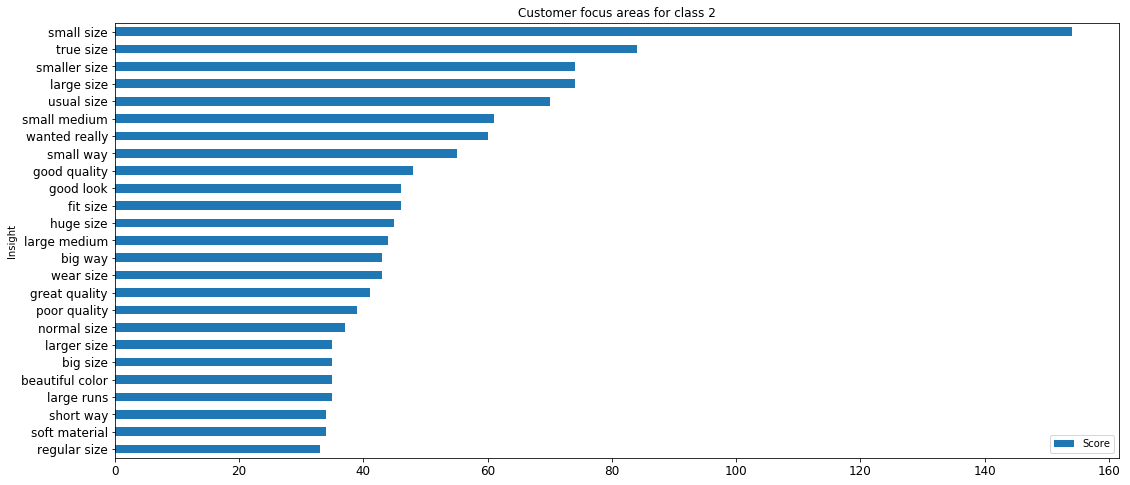

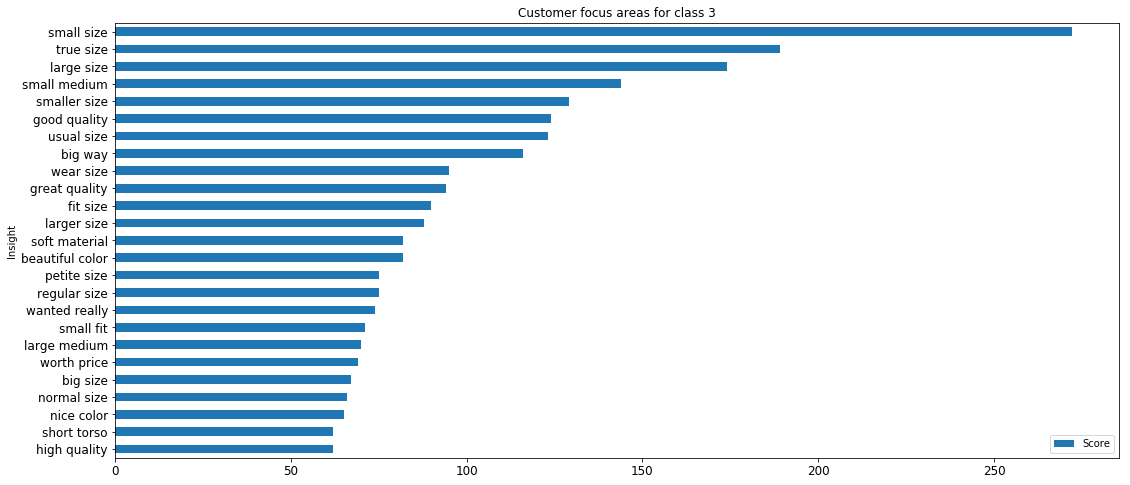

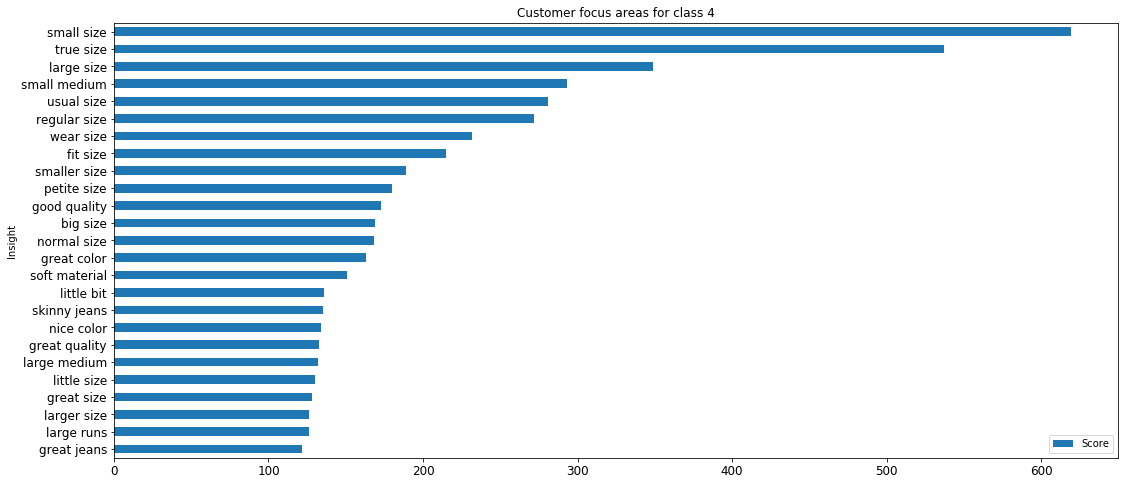

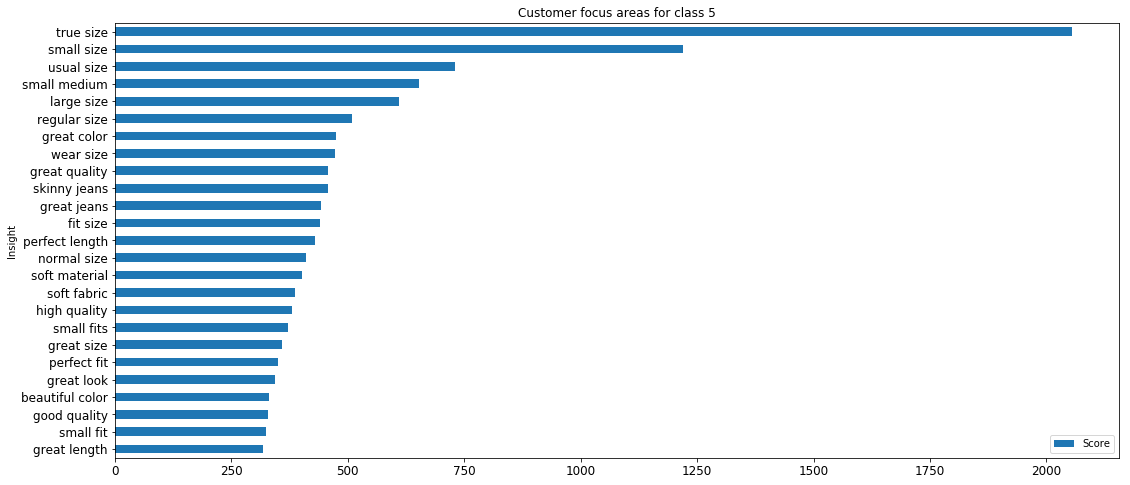

In [10]:
for i in range(1,6):
    _ = data[data[CLASS] == i][REVIEW].values
    kws = []
    for r in tqdm(_):
        kws += relations(r)
    c = Counter(kws)
    _ = pd.DataFrame(c.most_common())
    _.columns = ['Insight', 'Score']
    _.set_index(_['Insight'], inplace=True)
    _.drop(['Insight'], axis=1, inplace=True)
    _.head(25)[::-1].plot.barh(figsize=(18,8), fontsize=12, title=f'Customer focus areas for class {i}')